In [120]:
# we don't want to see future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import yfinance as yf

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sentiment_analysis import sentiment_analysis_microservice


In [213]:
WINDOW_SIZE = 100
SENTIMENT_IN_MODEL = 1
NUM_TO_PREDICT = 10

EXTRAPOLATE_DAYS = 200
DAYS_TO_TAKE_FROM_EACH_PREDICTION = 10

In [122]:
# get msft stock closing data
msft = yf.Ticker("MSFT")
msft_data = msft.history(period="max")
msft_df = pd.DataFrame(msft_data.Close)
msft_sentiment = sentiment_analysis_microservice('MSFT')

aapl = yf.Ticker("AAPL")
aapl_data = aapl.history(period="max")
aapl_df = pd.DataFrame(aapl_data.Close)
aapl_sentiment = sentiment_analysis_microservice('AAPL')

nvda = yf.Ticker("NVDA")
nvda_data = nvda.history(period="max")
nvda_df = pd.DataFrame(nvda_data.Close)
nvda_sentiment = sentiment_analysis_microservice('NVDA')

amzn = yf.Ticker("AMZN")
amzn_data = amzn.history(period="max")
amzn_df = pd.DataFrame(amzn_data.Close)
amzn_sentiment = sentiment_analysis_microservice('AMZN')

tsla = yf.Ticker("TSLA")
tsla_data = tsla.history(period="max")
tsla_df = pd.DataFrame(tsla_data.Close)
tsl_sentiment = sentiment_analysis_microservice('TSLA')

msft_df

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/dhruv/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/dhruv/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/dhruv/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/dhruv/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/dhruv/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Close
Date,
1986-03-13 00:00:00-05:00,0.060396
1986-03-14 00:00:00-05:00,0.062553
1986-03-17 00:00:00-05:00,0.063632
1986-03-18 00:00:00-05:00,0.062014
1986-03-19 00:00:00-05:00,0.060936
...,...
2023-10-18 00:00:00-04:00,330.109985
2023-10-19 00:00:00-04:00,331.320007
2023-10-20 00:00:00-04:00,326.670013


,Close
count,9481.000000
mean,45.977283
std,76.168438
min,0.056083
25%,3.397310
50%,19.096367
75%,35.296585
max,358.730469


<Axes: xlabel='Date'>

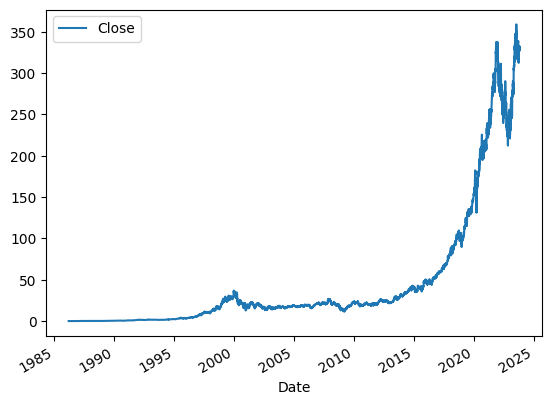

In [123]:
# get a summary of the data and graph
display(msft_df.describe())
msft_df.plot()

In [124]:
# create a function to create the data sets
def create_dataset_from_table(price_df, window_size, num_to_predict):
    close_list = price_df.Close.values
    dataset_x = []
    dataset_y = []

    for i in range(len(close_list) - window_size - num_to_predict):
        dataset_x.append(close_list[i:i + window_size])
        dataset_y.append(close_list[i + window_size:i + window_size + num_to_predict])
    
    return np.array(dataset_x), np.array(dataset_y)

In [155]:
msft_x, msft_y = create_dataset_from_table(msft_df, WINDOW_SIZE, NUM_TO_PREDICT)
aapl_x, aapl_y = create_dataset_from_table(aapl_df, WINDOW_SIZE, NUM_TO_PREDICT)
nvda_x, nvda_y = create_dataset_from_table(nvda_df, WINDOW_SIZE, NUM_TO_PREDICT)
amzn_x, amzn_y = create_dataset_from_table(amzn_df, WINDOW_SIZE, NUM_TO_PREDICT)
tsla_x, tsla_y = create_dataset_from_table(tsla_df, WINDOW_SIZE, NUM_TO_PREDICT)

In [156]:
def append_sentiment_to_stock(stock_x, stock_sentiment):
    new_stock_x = []
    for i in range(len(stock_x)):
        new_stock_x.append(np.append(stock_x[i], stock_sentiment))
    return np.array(new_stock_x)

msft_x = append_sentiment_to_stock(msft_x, msft_sentiment)
aapl_x = append_sentiment_to_stock(aapl_x, aapl_sentiment)
nvda_x = append_sentiment_to_stock(nvda_x, nvda_sentiment)
amzn_x = append_sentiment_to_stock(amzn_x, amzn_sentiment)
tsla_x = append_sentiment_to_stock(tsla_x, tsl_sentiment)

In [158]:

# combine each stock data to make dataset
data_x = np.concatenate((msft_x, aapl_x, nvda_x, amzn_x, tsla_x))
data_y = np.concatenate((msft_y, aapl_y, nvda_y, amzn_y, tsla_y))

In [159]:
data_x[0]

array([0.06039643, 0.06255335, 0.06363237, 0.06201412, 0.06093566,
       0.05931801, 0.05770034, 0.05608271, 0.05716112, 0.05877879,
       0.05985724, 0.05931801, 0.05877879, 0.05931801, 0.05985724,
       0.05985724, 0.05877879, 0.05931801, 0.06039643, 0.06093566,
       0.06201412, 0.06255335, 0.06255335, 0.06471086, 0.06525005,
       0.06309319, 0.06309319, 0.06201412, 0.06228374, 0.06848539,
       0.07279978, 0.07333902, 0.07118148, 0.06956383, 0.06848539,
       0.06848539, 0.06794617, 0.06848539, 0.06848539, 0.06902458,
       0.06848539, 0.06902458, 0.06956383, 0.06902458, 0.06902458,
       0.06956383, 0.06848539, 0.06794617, 0.06686772, 0.06686772,
       0.06686772, 0.06902458, 0.07118148, 0.07279978, 0.07549588,
       0.07333902, 0.07333902, 0.07279978, 0.07387819, 0.07387819,
       0.07064226, 0.07064226, 0.07064226, 0.06794617, 0.06794617,
       0.06740696, 0.06848539, 0.06794617, 0.06740696, 0.06767657,
       0.06848539, 0.06794617, 0.06686772, 0.06471086, 0.06417

In [160]:
# split df using 80% for training and 20% for testing with train_test_split
# NOTE: no validation set is used but can be added if desired in future

from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.2, shuffle=True)

In [166]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=(WINDOW_SIZE + SENTIMENT_IN_MODEL, 1)),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(NUM_TO_PREDICT)
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 101, 32)           4352      
                                                                 
 lstm_11 (LSTM)              (None, 32)                8320      
                                                                 
 dense_11 (Dense)            (None, 32)                1056      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 10)                330       
                                                                 
Total params: 14058 (54.91 KB)
Trainable params: 14058 (54.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [167]:
# train the model
history = model.fit(
    train_x,
    train_y,
    epochs=10
)

Epoch 1/10
900/900 [==============================] - 31s 33ms/step - loss: 1693.8680 - mae: 12.5867
Epoch 2/10
900/900 [==============================] - 30s 33ms/step - loss: 149.6169 - mae: 4.4408
Epoch 3/10
900/900 [==============================] - 30s 33ms/step - loss: 117.0511 - mae: 4.0156
Epoch 4/10
900/900 [==============================] - 30s 33ms/step - loss: 110.2019 - mae: 3.9031
Epoch 5/10
900/900 [==============================] - 30s 34ms/step - loss: 102.6569 - mae: 3.7849
Epoch 6/10
900/900 [==============================] - 30s 33ms/step - loss: 117.6156 - mae: 3.9349
Epoch 7/10
900/900 [==============================] - 30s 33ms/step - loss: 109.9035 - mae: 3.8787
Epoch 8/10
900/900 [==============================] - 30s 33ms/step - loss: 108.1721 - mae: 3.7972
Epoch 9/10
900/900 [==============================] - 30s 33ms/step - loss: 92.6044 - mae: 3.5923
Epoch 10/10
900/900 [==============================] - 30s 33ms/step - loss: 95.0240 - mae: 3.6166


In [214]:
# testing accuracy
model.evaluate(test_x, test_y)

  1/225 [..............................] - ETA: 4s - loss: 19.1940 - mae: 1.5743

225/225 [==============================] - 2s 8ms/step - loss: 173.0404 - mae: 4.3116


[173.04042053222656, 4.311646938323975]

In [215]:
# plot actual testing data vs predicted data
predictions = model.predict(msft_x)

# take the first prediction from each set of predictions
predictions = predictions[:,0]
predictions.shape

293/293 [==============================] - 2s 8ms/step


(9371,)

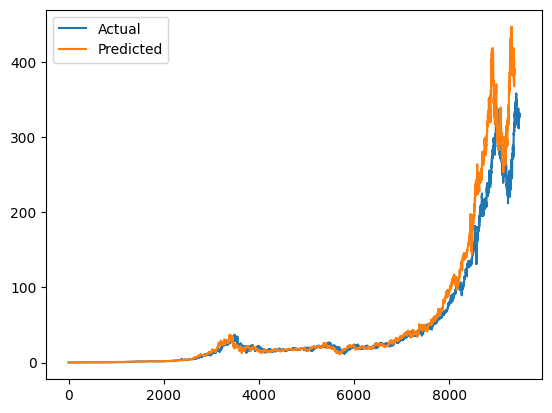

In [216]:
plt.plot(np.array(msft_df.Close), label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [217]:
# use the model to predict the last EXTRAPOLATE_DAYS
last_window = np.array(msft_df.Close)[-WINDOW_SIZE:]
complete_predictions = np.array([])
prediction = model.predict(np.array([last_window]))
prediction[0]

1/1 [==============================] - 0s 16ms/step


array([382.4833 , 382.90717, 383.21225, 383.06287, 383.35654, 382.80704,
       382.58362, 383.00928, 382.57104, 382.31546], dtype=float32)

In [218]:
while len(complete_predictions) < EXTRAPOLATE_DAYS:
    prediction = model.predict(np.array([np.append(last_window, msft_sentiment)]))
    complete_predictions = np.concatenate((complete_predictions, prediction[0]))
    last_window = np.concatenate((last_window[DAYS_TO_TAKE_FROM_EACH_PREDICTION:], prediction[0]))

complete_predictions

1/1 [==============================] - 0s 17ms/step


array([405.5786438 , 406.00244141, 406.36685181, 406.12612915,
       406.54281616, 405.93856812, 405.69741821, 406.16723633,
       405.67871094, 405.4588623 , 481.11480713, 481.49038696,
       481.87353516, 481.62182617, 482.12316895, 481.3298645 ,
       480.90344238, 481.63980103, 480.95758057, 480.60522461,
       493.17050171, 493.53143311, 493.91543579, 493.64883423,
       494.16351318, 493.34017944, 492.88528442, 493.66616821,
       492.93701172, 492.56314087, 493.66040039, 494.02062988,
       494.4045105 , 494.13742065, 494.65249634, 493.82803345,
       493.37188721, 494.15463257, 493.42352295, 493.04901123,
       493.6812439 , 494.04144287, 494.42532349, 494.15817261,
       494.67324829, 493.84872437, 493.39254761, 494.17538452,
       493.44412231, 493.0696106 , 493.68527222, 494.04553223,
       494.42944336, 494.16223145, 494.67727661, 493.8527832 ,
       493.39657593, 494.17941284, 493.44824219, 493.07366943,
       493.68875122, 494.04904175, 494.43283081, 494.16

In [220]:
model_completed_predictions = np.array(list(predictions) + list(complete_predictions))
model_completed_predictions

array([1.71763420e-01, 1.73675179e-01, 1.74905300e-01, ...,
       4.94194672e+02, 4.93463348e+02, 4.93088837e+02])

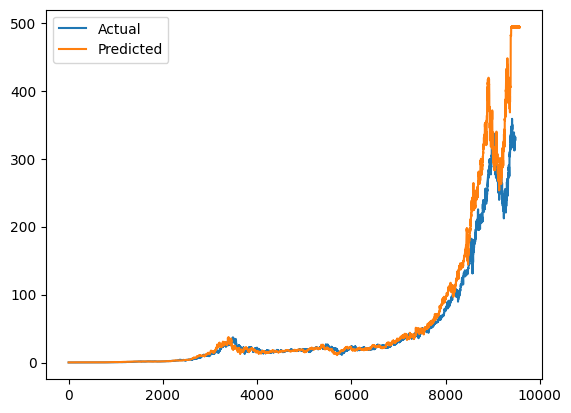

In [221]:
plt.plot(np.array(msft_df.Close), label='Actual')
plt.plot(model_completed_predictions, label='Predicted')
plt.legend()
plt.show()

In [222]:
len(model_completed_predictions)

9571

In [226]:
# save the model
model.save('stock_predictor.h5')

/Users/dhruv/Documents/TestCode/COMP3900/3900_project/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
